In [1]:
import numpy as np
from rich.pretty import pprint
from matplotlib import pyplot as plt
from dataclasses import dataclass

from pruning import thresholds, utils

In [2]:
nstages = 63
nparams = 3
target_snr = 10
ntrials = 2**12
ducy_max = 0.3

param_complexity_k = np.sum(np.arange(nparams) + 1)
tt = np.arange(3, nstages + 1)
branching_pattern = np.array([2, 4] + list((tt / (tt-1))**param_complexity_k), dtype=np.float32)
profile = np.zeros(64, dtype=np.float32)
profile[29:34] += np.array([4, 14, 22, 14, 4])

In [3]:
thresh_bound_scheme = thresholds.bound_scheme(nstages, target_snr)
thresh_survival_scheme = thresholds.trials_scheme(nstages, nparams, 1)
thresh_minimi_scheme = np.minimum(thresh_bound_scheme, thresh_survival_scheme)
survive_probs = 1 / branching_pattern
survive_probs[0:4] = 1
thresh_constant_scheme = thresholds.determine_scheme(survive_probs, branching_pattern, profile, ntrials, target_snr).thresholds

schemes = {"bound": thresh_bound_scheme, "survival": thresh_survival_scheme, "minimi": thresh_minimi_scheme, "constant": thresh_constant_scheme}
states = {scheme_key: thresholds.evaluate_scheme(scheme_value, branching_pattern, profile, ntrials, target_snr)
          for scheme_key, scheme_value in schemes.items()}
states["bound"].print_summary()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Threshold scheme summary:
Branching mean exponential growth: 1.44
Branching max exponential growth: 11.390625
Total enumerated options: 32.86
Pruning complexity: 3205.20
Crude survival probability: 0.06
Total cost: 55118.36
Number of independent trials: 6.30
Total survival probability: 0.31


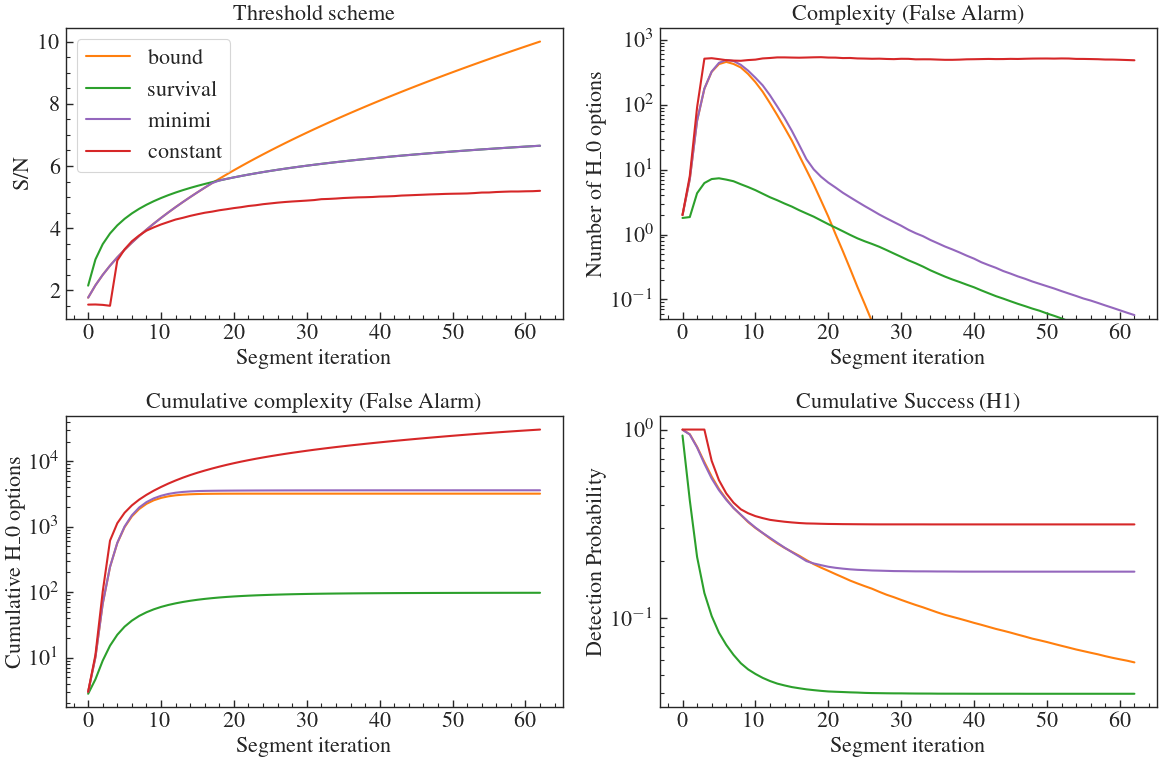

In [4]:
utils.set_seaborn(**{"lines.linewidth": 1.5})
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(12,8))

colors = {"bound": "tab:orange", "survival": "tab:green", "minimi": "tab:purple", "constant": "tab:red"}
x = np.arange(nstages)

for scheme_name, scheme_arr in schemes.items():
    ax1.plot(x, scheme_arr, label=scheme_name, c=colors[scheme_name])
ax1.set_xlabel("Segment iteration")
ax1.set_ylabel("S/N")
ax1.set_title("Threshold scheme")
ax1.legend()
for ax, info, title, ylabel in [
    (ax2, "complexity", "Complexity (False Alarm)", "Number of {H_{0} options"),
    (ax3, "complexity_cumul", "Cumulative complexity (False Alarm)", "Cumulative {H_{0} options"),
    (ax4, "success_h1_cumul", "Cumulative Success (H1)", "Detection Probability")
]:
    for scheme_name, scheme_arr in schemes.items():
        ax.plot(x, states[scheme_name].get_info(info), label=scheme_name, c=colors[scheme_name])
    ax.set_xlabel("Segment iteration")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_yscale("log")
ax2.set_ylim(0.05, 1500)

plt.tight_layout()
plt.savefig("figures/thresholding_comparison.png", dpi=300)

### Dynamic thresholding

In [5]:
dyn = thresholds.DynamicThresholdScheme(branching_pattern, profile, nparams, ntrials=2**10, nprobs=20, snr_final=10,
                                        nthresholds=100, ducy_max=ducy_max, beam_width=1.5)
dyn.run(thresh_neighbours_tol=15)
results_file = dyn.save(outdir=".")

Output()

In [6]:
dyn_results = thresholds.DynamicThresholdSchemeAnalyser.from_file(results_file)

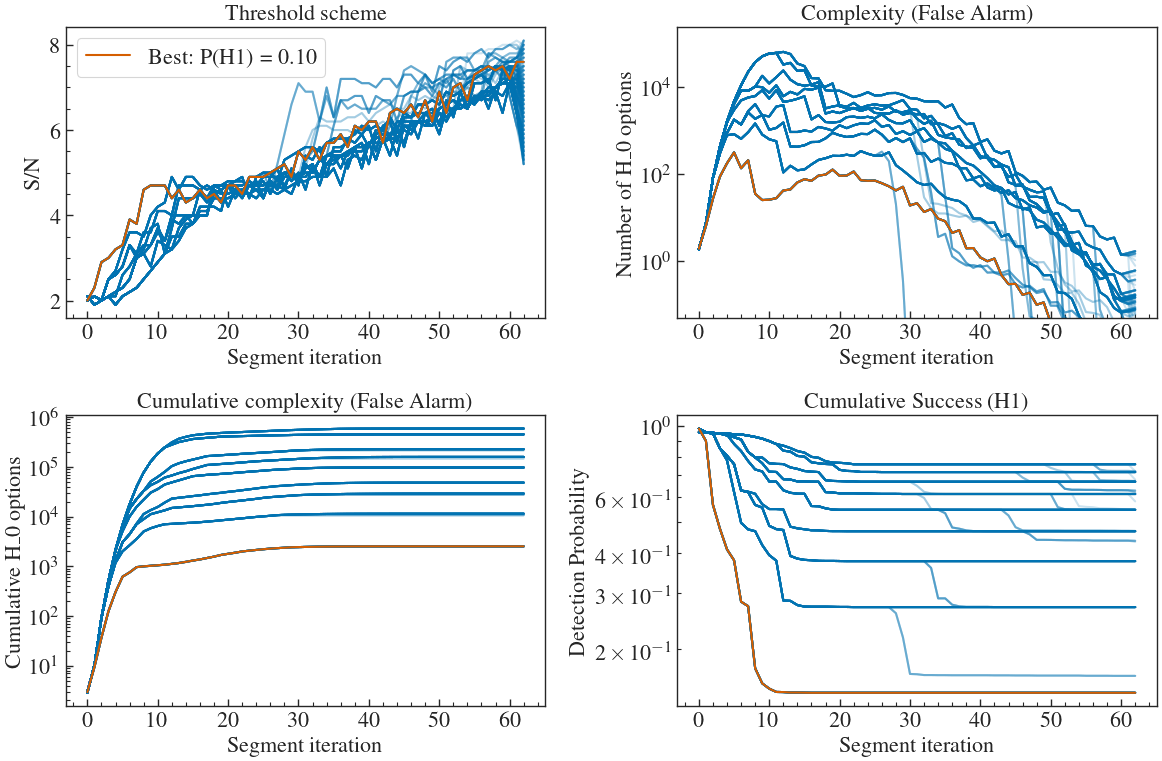

In [7]:
fig = dyn_results.plot_paths(best_min_prob=0.1, min_prob=0.01)
plt.tight_layout()
plt.savefig("figures/thresholding_dynamic.png", dpi=300)

### Dynamic thresholding comparison

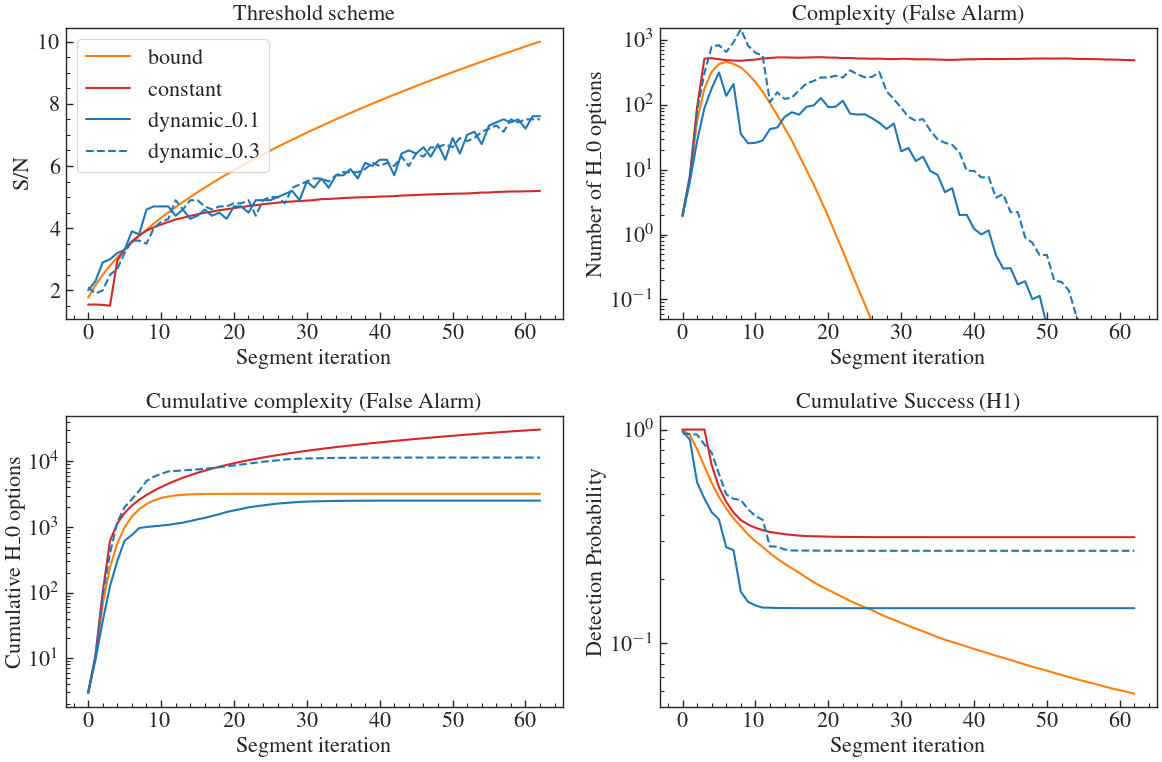

In [9]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, figsize=(12,8))

colors = {"bound": "tab:orange", "constant": "tab:red", "dynamic_0.1": "tab:blue", "dynamic_0.3": "tab:blue"}
line_styles = {"bound": "-", "constant": "-", "dynamic_0.1": "-", "dynamic_0.3": "--"}
states["dynamic_0.1"], states["dynamic_0.3"] = dyn_results.backtrack_best(min_probs=[0.1, 0.2])
schemes["dynamic_0.1"] = states["dynamic_0.1"].thresholds
schemes["dynamic_0.3"] = states["dynamic_0.3"].thresholds


x = np.arange(nstages)
for plot_keys in colors.keys():
    ax1.plot(x, schemes[plot_keys], label=plot_keys, c=colors[plot_keys], ls=line_styles[plot_keys])
ax1.set_xlabel("Segment iteration")
ax1.set_ylabel("S/N")
ax1.set_title("Threshold scheme")
ax1.legend()
for ax, info, title, ylabel in [
    (ax2, "complexity", "Complexity (False Alarm)", "Number of {H_{0} options"),
    (ax3, "complexity_cumul", "Cumulative complexity (False Alarm)", "Cumulative {H_{0} options"),
    (ax4, "success_h1_cumul", "Cumulative Success (H1)", "Detection Probability")
]:
    for plot_keys in colors.keys():
        ax.plot(x, states[plot_keys].get_info(info), label=plot_keys, c=colors[plot_keys], ls=line_styles[plot_keys])
    ax.set_xlabel("Segment iteration")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_yscale("log")
ax2.set_ylim(0.05, 1500)

plt.tight_layout()
plt.savefig("figures/thresholding_dynamic_comparison.png", dpi=300)